# **Goodness of Fit** 

The goodness of fit of a statistical model describes how well it fits a set of observations. Measures of goodness of fit typically summarize the discrepancy between observed values and the values expected under the model in question. Such measures can be used in statistical hypothesis testing, e.g. to test for normality of residuals, to test whether two samples are drawn from identical distributions (see Kolmogorov–Smirnov test), or whether outcome frequencies follow a specified distribution (see Pearson's chi-square test). In the analysis of variance, one of the components into which the variance is partitioned may be a lack-of-fit sum of squares.

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

from src.config import CREDIT_RISK_DATA_DIR

In [220]:
os.chdir(CREDIT_RISK_DATA_DIR)

df = pd.read_csv("credit_risk_dataset.csv")

In [221]:
x_numeric_cols = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length",
    "loan_amnt",
]
x_categorical_col = "loan_grade"

In [222]:
scaler = StandardScaler()

for vars in x_numeric_cols:
    df[f"{vars}_scaled"] = scaler.fit_transform(df[[vars]])

In [223]:
encoder = OneHotEncoder()

series = df[x_categorical_col]
df = pd.get_dummies(data=df, columns=[x_categorical_col], drop_first=True)
df[x_categorical_col] = series

In [224]:
target_variable = "loan_amnt"
transformed_feature_variables = [
    "person_age_scaled",
    "person_income_scaled",
    "loan_grade_B",
    "loan_grade_C",
    "loan_grade_D",
    "loan_grade_E",
    "loan_grade_F",
    "loan_grade_G",
]
y = df[target_variable]
X = df[transformed_feature_variables]

In [225]:
# First, split into Train (80%) and Temp (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

26064 6517


In [226]:
# scikit-learn model
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)
y_test_predicted = sklearn_model.predict(X_test)
y_train_predicted = sklearn_model.predict(X_train)
residuals_test = np.array(y_test) - y_test_predicted
residuals_train = np.array(y_train) - y_train_predicted

In [227]:
# statsmodels model
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
features_plus_string = " + ".join(transformed_feature_variables)
train_df = sm.add_constant(train_df)
sm_model = sm.OLS.from_formula(f"{target_variable} ~ {features_plus_string}", data=train_df)
sm_results = sm_model.fit()

y_test_predicted_sm = sm_results.predict(X_test)
y_train_predicted_sm = sm_results.predict(X_train)
residuals_test_sm = np.array(y_test) - y_test_predicted
residuals_train_sm = np.array(y_train) - y_train_predicted

sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              loan_amnt   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     351.9
Date:                Mon, 07 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:22:28   Log-Likelihood:            -2.6373e+05
No. Observations:               26064   AIC:                         5.275e+05
Df Residuals:                   26055   BIC:                         5.275e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             8547.5126     64.654    132.205      0.000    8420.788    8674.237
loan_grade_B[T.True]  1426.8355     92.046     15.501      0.000    1246.421    1607.250
loan_grade_C[T.True]   682.7378    105.595      6.466      0.000     475.766     889.709
loan_grade_D[T.True]  2567.4227    128.894     19.919      0.000    2314.784    2820.062
loan_grade_E[T.True]  3958.6687    227.488     17.402      0.000    3512.780    4404.557
loan_grade_F[T.True]  5638.6710    442.469     12.744      0.000    4771.408    6505.934
loan_grade_G[T.True]  8071.2792    851.131      9.483      0.000    6403.015    9739.544
person_age_scaled      -12.1198     37.539     -0.323      0.747     -85.698      61.458
person_income_scaled  1599.0958     36.843     43.403      0.000    1526.881    1671.310
==============================================================================
Omnibus:                     6485.235   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           413051.352
Skew:                           0.224   Prob(JB):                         0.00
Kurtosis:                      22.497   Cond. No.                         25.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## **Relative Model Performance**

### **Akaike information criterion (AIC)**

Akaike information criterion (AIC) is a statistical method that aims to determine the model that truly explains the variance in the dependent variable with the fewest number of independent variables (parameters). With this, it helps to select a simpler model containing fewer parameters over a complex model.

AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model.

In estimating the amount of information lost by a model, AIC deals with the trade-off between the goodness of fit of the model and the simplicity of the model. In other words, AIC deals with both the risk of overfitting and the risk of underfitting.

The Akaike information criterion is named after the Japanese statistician Hirotugu Akaike, who formulated it. It now forms the basis of a paradigm for the foundations of statistics and is also widely used for statistical inference.

Suppose that we have a statistical model of some data. Let $k$ be the number of estimated parameters in the model. Let 
${\displaystyle {\hat {L}}}$ be the maximized value of the likelihood function for the model. Then the AIC value of the model is the following:

${\displaystyle \mathrm {AIC} \,=\,2k-2\ln({\hat {L}})}$

Given a set of candidate models for the data, the preferred model is the one with the minimum AIC value. Thus, AIC rewards goodness of fit (as assessed by the likelihood function), but it also includes a penalty that is an increasing function of the number of estimated parameters. 

Note that AIC tells nothing about the absolute quality of a model, only the quality relative to other models. Thus, if all the candidate models fit poorly, AIC will not give any warning of that. Hence, after selecting a model via AIC, it is usually good practice to validate the absolute quality of the model. Such validation commonly includes checks of the model's residuals (to determine whether the residuals seem like random) and tests of the model's predictions.

Note that if all the models have the same $k$, then selecting the model with minimum AIC is equivalent to selecting the model with minimum $RSS$ — which is the usual objective of model selection based on least squares.

In [228]:
print(sm_results.aic)

527470.9205424661


### **Bayesian information criterion (BIC)**

The formula for the Bayesian information criterion (BIC) is similar to the formula for AIC, but with a different penalty for the number of parameters. With AIC the penalty is $2k$, whereas with BIC the penalty is $k\ln(n)$. Similar to AIC, lower BIC values indicate better model fit. The formula for BIC is expressed as follows:

${\displaystyle \mathrm {BIC} =k\ln(n)-2\ln({\widehat {L}}).\ }$

$n$ is the number of data points in $X$. However, a lower BIC does not necessarily indicate one model is better than another. Because it involves approximations, the BIC is merely a heuristic. In particular, differences in BIC should never be treated like transformed Bayes factors.

It is important to keep in mind that the BIC can be used to compare estimated models only when the numerical values of the dependent variable are identical for all models being compared. 

In [229]:
print(sm_results.bic)

527544.4353354437


## **Absolute Model Performance**

### **Regression Models**

Residual analysis is a fundamental diagnostic technique used to evaluate the goodness-of-fit and assumptions of a statistical model, especially regression models. A residual is the difference between an observed value and the value predicted by the model.

By studying residuals, we can assess whether the model captures the data well, or if there are systematic patterns it fails to explain. Ideally, residuals should resemble white noise: randomly scattered around zero, with constant variance and no autocorrelation.


#### **Histogram of Residuals**

Checks whether residuals are approximately normally distributed. While not always required (especially for count models), it helps identify skewness or outliers.


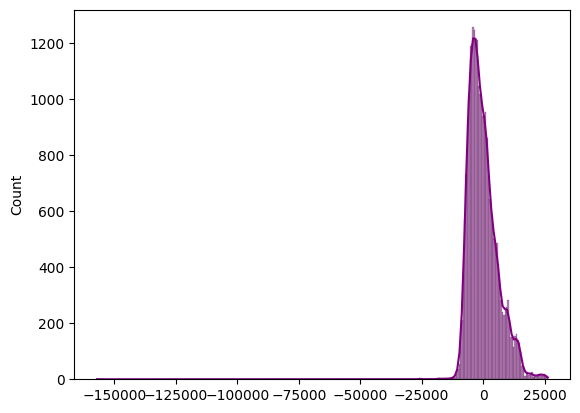

In [230]:
sns.histplot(residuals_train, kde=True, color="purple")
plt.show()

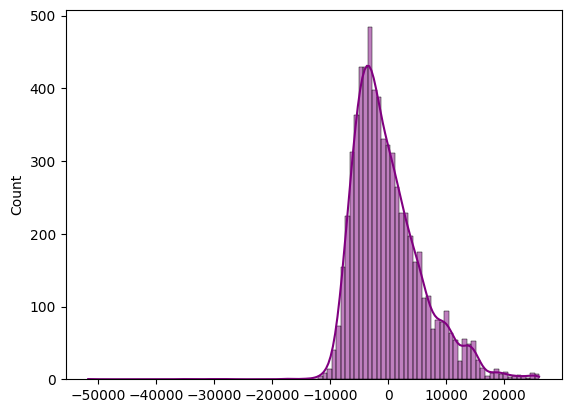

In [231]:
sns.histplot(residuals_test, kde=True, color="purple")
plt.show()

#### **QQ Plot**

In statistics, a Q–Q plot (quantile–quantile plot) is a probability plot, a graphical method for comparing two probability distributions by plotting their quantiles against each other. A point (x, y) on the plot corresponds to one of the quantiles of the second distribution (y-coordinate) plotted against the same quantile of the first distribution (x-coordinate). 

In most cases, this type of plot is used to determine whether or not a set of data follows a normal distribution.

As a rule of thumb, the more that the points in a Q-Q plot lie on a straight diagonal line, the more normally distributed the data.

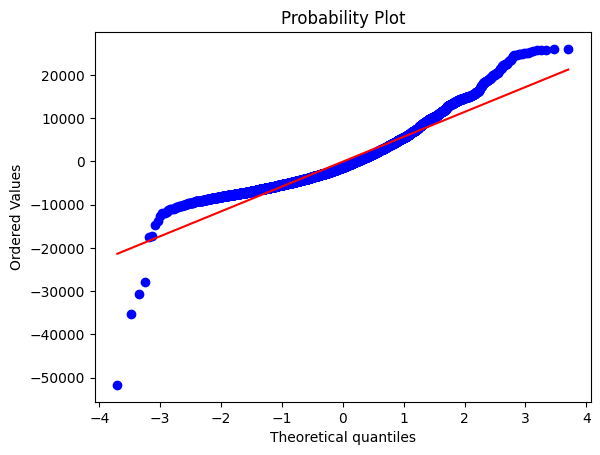

In [232]:
# Create the Q-Q plot
stats.probplot(residuals_test, dist="norm", plot=plt)
plt.show()

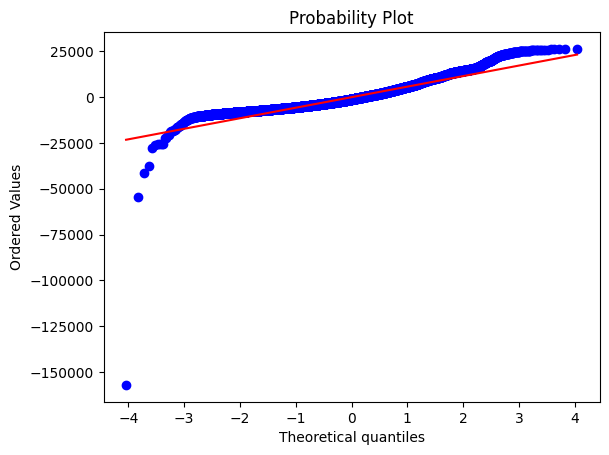

In [233]:
stats.probplot(residuals_train, dist="norm", plot=plt)
plt.show()

#### **Residuals vs Predicted Values**

You will plot residuals vs fitted values. A well-fitted model should show no pattern—residuals should be evenly spread around the horizontal line at zero. Patterns (e.g., U-shapes, fanning out) may suggest non-linearity or heteroscedasticity (non-constant variance).


<Axes: >

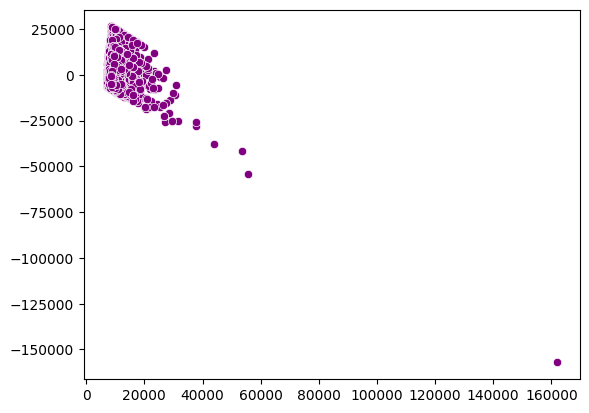

In [234]:
sns.scatterplot(x=y_train_predicted, y=residuals_train, color="purple")

<Axes: >

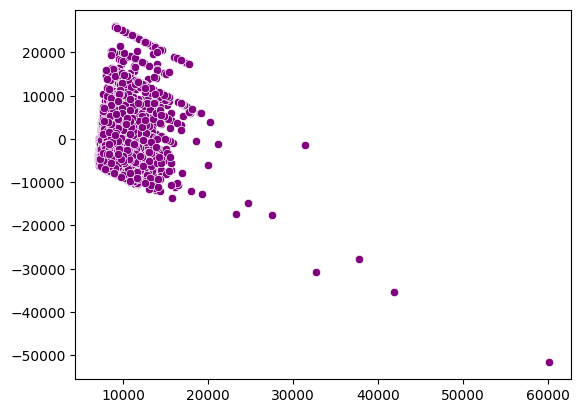

In [235]:
sns.scatterplot(x=y_test_predicted, y=residuals_test, color="purple")


#### **Pearson Residuals**

The Pearson residual is a standardized version of the raw residual that accounts for the expected variance in the model. It is defined as:

$r = \Large\frac{y_i-\hat{y}_i}{\text{Var}(y_i)}$

Pearson residuals are particularly useful for GLMs (Generalized Linear Models) where variance is not constant and depends on the mean. Large absolute values (e.g., > 2 or < -2) indicate poor model fit or potential outliers.

In practice, plotting Pearson residuals versus predicted values (or another feature) helps identify lack of fit or areas where the model may be biased or underperforming.

<Axes: ylabel='Count'>

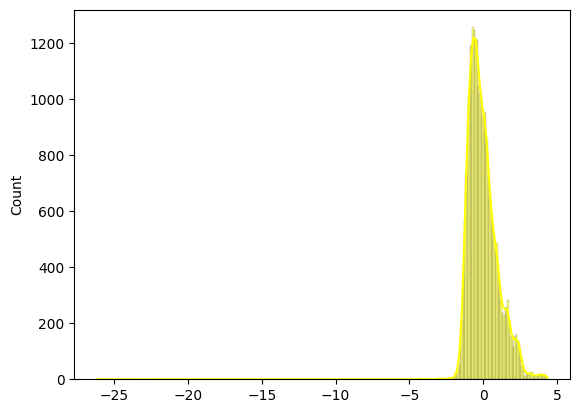

In [236]:
pearson_resid = sm_results.resid_pearson
sns.histplot(pearson_resid, kde=True, color="yellow")

<Axes: ylabel='Count'>

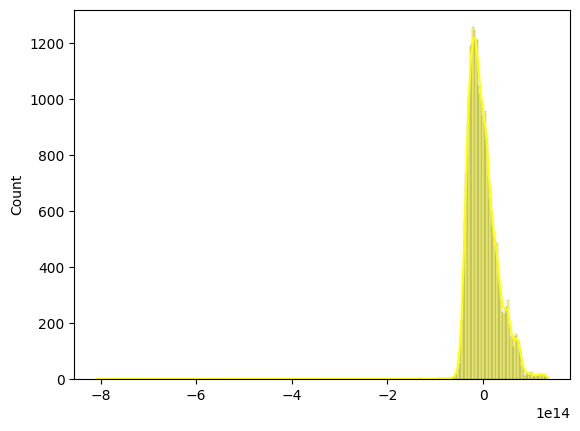

In [237]:
sigma_hat = np.sqrt((sum(residuals_train) ** 2) / (len(residuals_train) - 2))
pearson_resid = residuals_train / sigma_hat
sns.histplot(pearson_resid, kde=True, color="yellow")

#### **Sum of Squares Total (SST)**

The sum of squared differences between individual data points $y_i$ and the mean of the response variable $y$.

${\displaystyle \operatorname {SST} =\sum _{i=1}^{n}(y_{i}-\bar y)^{2}}$

In [238]:
sst = np.sum((y_train - y_train.mean()) ** 2)
print(sst)

1039620255598.8865


#### **Sum of Squares Regression (SSR)**

The sum of squared differences between predicted data points $ŷ_i$ and the mean of the response variable $y$.

${\displaystyle \operatorname {SSR} =\sum _{i=1}^{n}(\hat y_{i}- \bar y_i)^{2}}$

In [239]:
ssr = np.sum((y_train_predicted - y_train.mean()) ** 2)
print(ssr)

101381489331.76474


#### **Sum of Squares Error (SSE)**

The residual sum of squares (RSS), also known as the sum of squared residuals (SSR) or the sum of squared estimate of errors (SSE), is the sum of the squares of residuals (deviations predicted from actual empirical values of data). A small RSS indicates a tight fit of the model to the data. It is used as an optimality criterion in parameter selection and model selection.

${\displaystyle \operatorname {SSE} =\sum _{i=1}^{n}(y_{i}-\hat y_i)^{2}}$

In [240]:
sse = np.sum((y_train - y_train_predicted) ** 2)
print(sse)

938238766267.1218


#### **Mean Squared Error (MSE)**

Mean Squared Error (MSE) is one of the most common metrics used for evaluating the performance of regression models. It measures the average of the squares of the errors—that is, the average squared difference between the predicted and actual values.

${\displaystyle \operatorname {MSE} =\frac{1}{n}\sum _{i=1}^{n}(y_{i}-f(x_{i}))^{2}}$

The smaller the MSE, the closer your model’s predictions are to reality. In this case, an MSE of $x$ suggests that, on average, your model’s predictions deviate by approximately $x$ units from the true exam scores.

In [241]:
print(mean_squared_error(y_true=y_train, y_pred=y_train_predicted))
print(mean_squared_error(y_true=y_train, y_pred=y_train_predicted_sm))
print(sse / len(y_train))

print(mean_squared_error(y_true=y_test, y_pred=y_test_predicted))
print(mean_squared_error(y_true=y_test, y_pred=y_test_predicted_sm))

35997497.171083555
35997497.171083555
35997497.171083555
35575160.69463342
35575160.69463343


#### **Root Mean Squared Error (RMSE)**

RMSE is the square root of the MSE and is a more interpretable metric since it is a **standard deviation of prediction errors or residuals**. It indicates how spread out the data is around the line of best fit. RMSE also has the useful property of being on the same scale/units as the Target variable. Hence it is very intuitive to understand as well.

In [242]:
print(root_mean_squared_error(y_true=y_train, y_pred=y_train_predicted))
print(root_mean_squared_error(y_true=y_train, y_pred=y_train_predicted_sm))
print(np.sqrt(sse / len(y_train)))

print(root_mean_squared_error(y_true=y_test, y_pred=y_test_predicted))
print(root_mean_squared_error(y_true=y_test, y_pred=y_test_predicted_sm))

5999.791427298415
5999.791427298415
5999.791427298415
5964.49165433513
5964.491654335131


#### **Mean Absolute Error (MAE)**

Mean Absolute Error (MAE) is a metric used to measure the accuracy of a model by calculating the average absolute difference between the observed and predicted values. It is a common evaluation metric for regression models in machine learning. It is easier to interpret than MSE, as it’s in the same units as the target variable.

Unlike other metrics, MAE doesn’t square the errors, which means it gives equal weight to all errors, regardless of their direction. This property makes MAE particularly useful when you want to understand the magnitude of errors without considering whether they are overestimations or underestimations.

Unlike some other metrics, MAE is less sensitive to extreme values (outliers) in the data. This makes it a suitable choice when your dataset contains outliers that might skew other metrics like Mean Squared Error (MSE).

It’s important to compare the MAE to the scale of the target variable. For instance, if you’re predicting house prices and your MAE is $10,000, that might be considered a good result. However, the same MAE might be unacceptable if you’re predicting temperature in degrees Celsius.

In [243]:
print(mean_absolute_error(y_true=y_train, y_pred=y_train_predicted))
print(mean_absolute_error(y_true=y_train, y_pred=y_train_predicted_sm))
print(mean_absolute_error(y_true=y_test, y_pred=y_test_predicted))
print(mean_absolute_error(y_true=y_test, y_pred=y_test_predicted_sm))

4609.643839738779
4609.643839738779
4609.916694472126
4609.916694472126


#### **Mean Absolute Percentage Error (MAPE)**

The MAE is simply the absolute difference between the actual value and the predicted value. So: |58- 52| = 6

The MAPE is the same but divided by the actual value. So: |58–52|/58 = 0.103. The MAPE value is a percentage, so can be multiplied by 100. For this example, the difference is just greater than 10%.

From this we can see that the lower the value, the better the performance is for both metrics.

For this example, there is only one predicted value and one actual value; these metrics usually take in numerous values and are aggregated, so the MAE or MAPE values are summed up then divided by how many there are (hence, ‘mean’ values).

We can also see that the MAE is an easier metric to understand as it has the same units as the actual and predicted values but doesn’t take in the magnitude of the difference like MAPE. The MAPE can be more beneficial because it shows the percentage difference. The fact that MAE does not show the percentage difference can be a disadvantage when comparing the accuracy of different models, because the range of the predicted and actual values may differ.

In [244]:
print(mean_absolute_percentage_error(y_true=y_train, y_pred=y_train_predicted))
print(mean_absolute_percentage_error(y_true=y_train, y_pred=y_train_predicted_sm))
print(mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_predicted))
print(mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_predicted_sm))

0.8607095798924556
0.8607095798924551
0.8577060071174416
0.857706007117441


This following example shows a downside of MAPE: that the values are asymmetric, meaning that MAPE reports higher errors if the predicted value is higher than the actual value and reports lower errors if the predicted value is lower than the actual, even if the MAE is the same.

| Date | Actual | Predicted | MAE | MAPE |
|---------|--------|-----------|-----|------|
| Jan-22 | 600 | 300 | 300 | 0.5 |
| Feb-22 | 300 | 600 | 300 | 1 |

In the example table above, we can see that the MAE for both dates is 300, however, the MAPE is very different between them, depending on if it is the predicted or actual value that is the largest. Without the addition of the MAE, the MAPE score does not give as much insight.

MAE is great when focusing on one model or comparing models where the range of actual and predicted values are the same. Although MAE treats extreme values the same as normal values and can’t be used to compare models with different ranges. MAPE is best when comparing models with different ranges and understanding the percentage difference. However, MAPE is asymmetric, is more prone to skewing the data with extreme values and is affected by a division error if the actual value is zero.

#### **Coefficient of Determination ($R^2$)**

Measures the proportion of variance in the target variable explained by the model. Values close to 1 indicate a good fit, while values close to 0 indicate a poor fit. Used for linear regression tasks. The choice of goodness-of-fit measures depends on the context and goals of the analysis. While MSE and RMSE provide insights into error magnitude, MAE offers robustness to outliers. R², on the other hand, serves as an interpretable percentage indicating the explained variability. A balance of these measures ensures a comprehensive evaluation of regression model performance.

$R^2 = 1 - \Large\frac{SSE}{SST}$

Adjusted R-squared is a modified version of R-squared, accounting for the number of predictors in a multiple linear regression model.

In [245]:
print(r2_score(y_train, y_train_predicted))

0.0975178088208396


In [246]:
print(sm_results.rsquared)

0.0975178088208396


In practice, an $R^2=1$ will never happen, unless you are wildly overfitting your data with an overly complex model, or you are computing R² on a ridiculously low number of data points that your model can fit perfectly. All datasets will have some amount of noise that cannot be accounted for by the data. In practice, the largest possible R² will be defined by the amount of unexplainable noise in your outcome variable.

When is R² = 0? For R² to be null, RSS/TSS must be equal to 1. This is the case if RSS = TSS, that is, if the sum of squared errors of our model is equal to the sum of squared errors of a model predicting the mean. If you are better off just predicting the mean, then your model is really not doing a terribly good job. There are infinitely many reasons why this can happen, one of these being an issue with your choice of model – if, for example, if you are trying to model really non-linear data with a linear model. Or it can be a consequence of your data. If your outcome variable is very noisy, then a model predicting the mean might be the best you can do.

#### **Adjusted R-squared**

Adjusted R-squared adjusts the R-squared value based on the number of predictors in the model, providing a more accurate measure for multiple regression models. The adjusted $R_2$ can be negative, and its value will always be less than or equal to that of $R_2$. Unlike R2, the adjusted $R_2$ increases only when the increase in $R_2$ (due to the inclusion of a new explanatory variable) is more than one would expect to see by chance.

Adjusted $R_2$ can be interpreted as an instance of the bias-variance tradeoff. When we consider the performance of a model, a lower error represents a better performance. When the model becomes more complex, the variance will increase whereas the square of bias will decrease, and these two metrics add up to be the total error. Combining these two trends, the bias-variance tradeoff describes a relationship between the performance of the model and its complexity.

$R_2$ can be interpreted as the variance of the model, which is influenced by the model complexity. A high $R_2$ indicates a lower bias error because the model can better explain the change of $Y$ with predictors. For this reason, we make fewer (erroneous) assumptions, and this results in a lower bias error. Meanwhile, to accommodate fewer assumptions, the model tends to be more complex.

### **Classification Models**

In [247]:
target_variable = "loan_status"
transformed_feature_variables = [
    "person_age_scaled",
    "person_income_scaled",
    "loan_amnt_scaled",
    "loan_grade_B",
    "loan_grade_C",
    "loan_grade_D",
    "loan_grade_E",
    "loan_grade_F",
    "loan_grade_G",
]
y = df[target_variable]
X = df[transformed_feature_variables]

In [248]:
# First, split into Train (80%) and Temp (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

26064 6517


In [249]:
# scikit-learn model
sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, y_train)

y_test_predicted = sklearn_model.predict(X_test)
y_train_predicted = sklearn_model.predict(X_train)

In [250]:
# statsmodels model
train_df = sm.add_constant(X_train)
train_df[train_df.select_dtypes(include=["bool"]).columns] = train_df.select_dtypes(
    include=["bool"]
).astype(int)

test_df = sm.add_constant(X_test)
test_df[test_df.select_dtypes(include=["bool"]).columns] = test_df.select_dtypes(
    include=["bool"]
).astype(int)

sm_model = sm.GLM(y_train, train_df, family=sm.families.Binomial())
sm_results = sm_model.fit()

y_test_predicted_sm = sm_results.predict(test_df)
y_train_predicted_sm = sm_results.predict(train_df)

sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:                26064
Model:                            GLM   Df Residuals:                    26054
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10305.
Date:                Mon, 07 Jul 2025   Deviance:                       20609.
Time:                        15:22:31   Pearson chi2:                 1.52e+10
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2260
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.5651      0.041    -63.328      0.000      -2.644      -2.486
person_age_scaled       -0.0048      0.018     -0.269      0.788      -0.040       0.030
person_income_scaled    -2.2947      0.055    -41.943      0.000      -2.402      -2.187
loan_amnt_scaled         0.6691      0.021     32.169      0.000       0.628       0.710
loan_grade_B             0.4467      0.049      9.187      0.000       0.351       0.542
loan_grade_C             0.7680      0.052     14.777      0.000       0.666       0.870
loan_grade_D             2.6109      0.057     45.978      0.000       2.500       2.722
loan_grade_E             2.8864      0.094     30.568      0.000       2.701       3.071
loan_grade_F             3.4331      0.200     17.182      0.000       3.042       3.825
loan_grade_G             8.3393      1.781      4.681      0.000       4.848      11.831
========================================================================================
"""

#### **Confusion Matrix**

When creating a machine learning algorithm capable of making classification predictions, an important step in the process is to measure the model’s predictive power.

Let’s say we are fitting a machine learning model to try to predict whether or not an email is spam. We can pass the features of our evaluation set through the trained model and get an output list of the predictions our model makes. We then compare each of those predictions to the actual labels. There are four possible categories that each of the comparisons can fall under:

- **True Positive (TP)**: The algorithm predicted spam and it was spam
- **True Negative (TN)**: The algorithm predicted not spam and it was not spam
- **False Positive (FP)**: The algorithm predicted spam and it was not spam
- **False Negative (FN)**: The algorithm predicted not spam and it was spam

One common way to visualize these values is in a confusion matrix. In a confusion matrix the predicted classes are represented as columns and the actual classes are represented as rows.

In [264]:
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_test_predicted),
    index=["actual no", "actual yes"],
    columns=["predicted no", "predicted yes"],
)

test_conf_matrix

,predicted no,predicted yes
actual no,4827,245
actual yes,906,539


#### **Accuracy**

One method for determining the effectiveness of a classification algorithm is by measuring its accuracy statistic. Accuracy is calculated by finding the total number of correctly classified predictions (true positives and true negatives) and dividing by the total number of predictions.

In [265]:
accuracy_score(y_test, y_test_predicted)

0.8233849930949824

#### **Recall**

Accuracy can be a misleading statistic depending on our data and the problem we are trying to solve. Consider a model tasked with predicting spam in the email inboxes of top secret government employees who never use their work email addresses for online shopping or logging onto their favorite gaming apps. We can write a pretty simple and accurate classifier that always predicts False, the email is not spam. This classifier will be incredibly accurate since there are hardly ever any spam emails sent to those top secret emails, but this classifier will never be able to find the information we are actually interested in, when there is spam.

In this situation, a helpful statistic to consider is recall. In our example, recall measures the ratio of correct spam predictions that our classifier found to the total number of spam emails. 

Recall is the ratio of correct positive predictions classifications made by the model to all actual positives.

In [266]:
recall_score(y_test, y_test_predicted)

0.37301038062283737

#### **Precision**

Unfortunately, recall isn’t a perfect statistic either (spoiler alert! There is no perfect statistic). For example, we could create a spam email classifier that always returns True, the email is spam. This particular classifier would have low accuracy, but the recall would be 1 because it would be able to accurately find every spam email.

In this situation, a helpful statistic to understand is precision. In our email spam classification example, precision is the ratio of correct spam email predictions to the total number of spam predictions.

Precision is the ratio of correct positive classifications to all positive classifications made by the model.

In [267]:
precision_score(y_test, y_test_predicted)

0.6875

#### **F1-Score**

It is often useful to consider both the precision and recall when attempting to describe the effectiveness of a model. The F1-score combines both precision and recall into a single statistic, by determining their harmonic mean. The harmonic mean is a method of averaging.

We use the **harmonic mean** rather than the traditional arithmetic mean because we want the F1-score to have a low value when either precision or recall is 0.

In [268]:
f1_score(y_test, y_test_predicted)

0.48362494392104083

#### **Receiver Operating Characteristic (ROC) Curve**

We have examined how changing the threshold can affect the logistic regression predictions. There is a continuum of predictions available in a single model by varying the threshold incrementally from zero to one. For each of these thresholds, the True Positive Rate (TPR) and the False Positive Rate (FPR) can be calculated and then plot. The resulting curve these points form is known as the Receiver Operating Characteristic (ROC) curve.

In the ROC curve plotted above, the True Positive Rate (TPR = TP / TP + FN) is on the y-axis and the False Positive Rate (FPR = FP / TN + FP) is on the x-axis. The ROC curve is the orange line and the dashed blue line is the Dummy Classification line, which is the equivalent of random guessing.

Notice there are three data points on the ROC curve, each labeled with their threshold values. The classification threshold of .5 will give us a TPR of about .65 with an FPR of about .28. For our specific data, we want a higher TPR so that we catch every malignant tumor. We might select a lower threshold of .25 so that our TPR is about .8, even though this may give us an FPR of about .4. 

The ROC curve can help us decide on a threshold that best fits our specific classification problem.

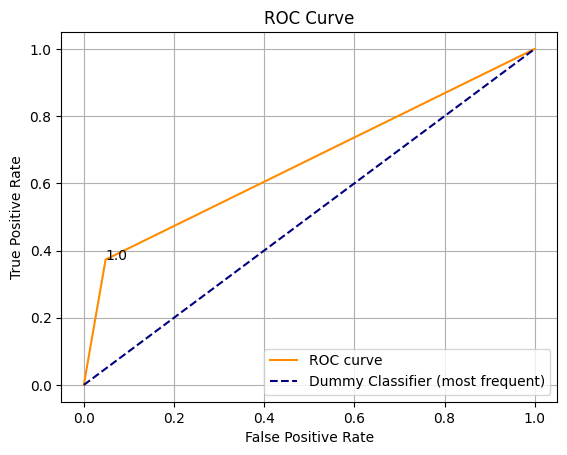

In [269]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_predicted)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")


idx = list(range(len(thresholds)))[1::4]
for i in idx:
    plt.text(fpr[i], tpr[i], thresholds[i].round(2))

clf = DummyClassifier(strategy="most_frequent", random_state=0)
clf.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

plt.plot(
    fpr,
    tpr,
    color="navy",
    linestyle="--",
    label="Dummy Classifier (most frequent)",
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.legend(loc="lower right")
plt.show()

#### **Area Under the Curve (AUC)**

While the ROC curve measures the probabilities, the AUC (Area Under the Curve) gives us a single metric for separability. The AUC tells us how well our model can distinguish between the two classes. An AUC score close to 1 is a near-perfect classifier, whereas a value of 0.5 is equivalent to random guessing and a value of 0 is guessing everything incorrectly. To visualize different AUC scores, look at the ROC curve plots below:

In [263]:
roc_auc_score(y_test, y_test_predicted)

0.6623529821095259

#### **Gini Index**

The Gini index is another metric used to evaluate model performance. It is commonly applied in credit score models and measures the effectiveness of discriminating between good and bad observations. The Gini index can be defined based on the area under the ROC curve (AUC).

$\text{Gini} = 2\times \text{AUC} - 1$

The maximum value for AUC is 1, and the minimum is 0 (some would argue it is 0.5 as well). Therefore, the Gini index ranges from -1 (Gini = 2 * 0–1 = -1) to 1 (Gini = 2 * 1–1 = 1). Since the Gini index uses AUC in its calculation, the interpretation is similar: values close to 1 indicate good performance. However, the Gini index may be easier to explain when we have a Gini of 0 as it implies the model is as good as flipping a fair coin.

In [ ]:
2 * roc_auc_score(y_test, y_test_predicted) - 1

0.32470596421905173

### **Forecasting Models**


#### **Autocorrelation of Residuals**

Autocorrelation in residuals is a critical aspect of time series analysis and regression modeling. It refers to the correlation of a signal with a delayed copy of itself as a function of delay. Autocorrelation in residuals indicates that there is some pattern left in the residuals that the model has not captured, which can lead to inefficiency in the model estimates and affect inference. 


- Positive Autocorrelation: Indicates that positive values tend to be followed by positive values, and negative values tend to be followed by negative values.
- Negative Autocorrelation: Indicates that positive values tend to be followed by negative values and vice versa.

Several methods can be used to test for autocorrelation in residuals, including visual inspection through plots and statistical tests. Here we discuss 3 main methods for Test the Autocorrelation of the Residuals in R.

- Visual Inspection using ACF Plot
- Durbin-Watson Test
- Ljung-Box Test

##### **ACF**

The Autocorrelation Function (ACF) plot is a graphical tool that shows the correlation of the time series with its lags. It helps in identifying the presence of autocorrelation in the residuals.

Significant autocorrelation at specific lags will appear as points outside the confidence bounds.

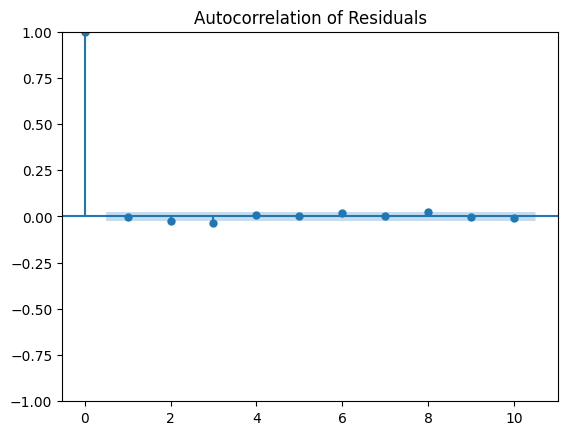

In [ ]:
# Plot autocorrelation
plot_acf(residuals_test, lags=10)
plt.title("Autocorrelation of Residuals")
plt.show()

##### **Dubin-Watson Statistic**

One of the assumptions of linear regression is that there is no correlation between the residuals. In other words, the residuals are assumed to be independent.

One way to determine if this assumption is met is to perform a Durbin-Watson test, which is used to detect the presence of autocorrelation in the residuals of a regression. This test uses the following hypotheses:

- $H_0$ (null hypothesis): There is no correlation among the residuals.
- $H_1$ (alternative hypothesis): The residuals are autocorrelated.

The test statistic is approximately equal to $2(1-r)$ where $r$ is the sample autocorrelation of the residuals. Thus, the test statistic will always be between 0 and 4 with the following interpretation:

- A test statistic of 2 indicates no serial correlation.
- The closer the test statistics is to 0, the more evidence of positive serial correlation.
- The closer the test statistics is to 4, the more evidence of negative serial correlation.

As a rule of thumb, test statistic values between the range of 1.5 and 2.5 are considered normal. However, values outside of this range could indicate that autocorrelation is a problem.


In [ ]:
# Calculate Durbin-Watson statistic
dw_stat = durbin_watson(residuals_test)
print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: 2.0036592238174076


If you reject the null hypothesis and conclude that autocorrelation is present in the residuals, then you have a few different options to correct this problem if you deem it to be serious enough:

1. For positive serial correlation, consider adding lags of the dependent and/or independent variable to the model.
2. For negative serial correlation, check to make sure that none of your variables are overdifferenced.
3. For seasonal correlation, consider adding seasonal dummy variables to the model.

##### **Ljung-Box test**

The Ljung-Box test checks for autocorrelation at multiple lags simultaneously. It is a portmanteau test that assesses whether any of a group of autocorrelations of the residuals is different from zero. The null hypothesis is that the residuals are independently distributed, the alternative is that the residuals are not independently distributed; they exhibit serial correlation.. A low p-value (< 0.05) indicates that there is significant autocorrelation at one or more lags.

In [ ]:
# Perform the Ljung-Box test
ljung_box_result = acorr_ljungbox(y_train, lags=[10], return_df=True)

# Display the results
print(ljung_box_result)

     lb_stat  lb_pvalue
10  11.49543   0.320243



#### **Backtesting**

Backtesting is a term used in modeling to refer to testing a predictive model on historical data. The idea is to keep the later part of the data as test data so that we can evaluate the model against this test data.

![image](images/backtesting.png)


There are several metrics that can be used to evaluate how different between the actual values and the forecasted values, or how different between the orange line and the light blue line above.

Here are the some metrics that are used widely when evaluating the time series forecasting models.
- RMSE (Root Mean Square Error)
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)
- Ginis


### **Model Agnostic**



#### **Two-way KS Test**

The Kolmogorov-Smirnov (K-S) statistic is a non-parametric test used to compare a sample with a reference probability distribution or to compare two samples. It can be used to check the goodness of fit of a distribution to data.
In this context, we can use the K-S test to check whether the residuals (difference between actual and predicted values) of our regression model follow a normal distribution

The K-S statistic quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples.

If $F(x)$ is the cumulative distribution function (CDF) of the reference distribution and $S(x)$ is the empirical distribution function (EDF) of the sample data, then the K-S statistic D is given by:

$D=\max |F(x)-S(x)|$

Null Hypotheses

- One-sample: The data come from the specified distribution.
- Two-sample: The two samples come from the same distribution.

This technique used to compare the distribution of actual and predicted values. It’s particularly useful in the context of predictive models to understand if your model is consistently predicting across the full range of observed outcomes.

Here’s how you can conduct a bin-based two-way K-S test:

- Create equal-sized bins based on the range of actual values.
- For each bin, compute the cumulative distribution function (CDF) for both actual and predicted values.
- Calculate the maximum difference between these CDFs.



In [2]:
from scipy.stats import ks_2samp
import numpy as np

data1 = np.random.normal(0, 1, 100)
data2 = np.random.normal(0, 1.5, 100)
stat, p = ks_2samp(data1, data2)
print('D-statistic=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("Samples may come from the same distribution (fail to reject H₀)")
else:
    print("Samples come from different distributions (reject H₀)")

D-statistic=0.140, p=0.282
Samples may come from the same distribution (fail to reject H₀)


#### **Lift Ratio**

Lift is a measure of the effectiveness of a predictive model calculated as the ratio between the results obtained with and without the predictive model. The idea is to evaluate how much better one can expect to do with the predictive model compared to without it.

For a given score decile (or percentile group):

$\text{Lift} = \frac{\text{Response rate in the group}}{\text{Overall response rate}}$
​

Or in binary terms:

$\text{Lift} = \frac{\text{Proportion of actual positives in group}}{\text{Proportion of positives in whole population}}$



#### **Cumulative Lift**

Cumulative lift is an extension of the lift metric that is assessed over a series of increasing data fractions. Essentially, as you consider more and more of the data (typically sorted by the model’s predicted probabilities), how does the lift value accumulate?

Cumulative lift is calculated by evaluating the model’s performance over progressively larger portions of the dataset, which has been sorted based on the model’s predicted probabilities or scores. A common way to visualize cumulative lift is through a lift chart. Here’s a step-by-step method to calculate cumulative lift. 

1. Predict Probabilities or Scores: Use your model to predict the probabilities or scores for each instance in your validation/test set.
2. Sort Data: Sort your dataset in descending order based on these predicted probabilities or scores.
3. Divide Data into Bins: Divide the sorted dataset into equal-sized bins (or deciles, quintiles, etc.). The top bin should contain the instances with the highest predicted probabilities or scores.
4. Calculate Cumulative Lift for Each Bin


In [5]:
import numpy as np

def cumulative_regression_lift(y_true, y_pred):
    """
    Compute the cumulative lift for regression.
    
    :param y_true: Array-like, true target values.
    :param y_pred: Array-like, predicted values by the model.
    :return: List of cumulative lift values.
    """
    # Sort y_true and y_pred by y_pred values
    sorted_indices = np.argsort(y_pred)
    y_true_sorted = y_true[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    
    cumulative_lifts = []
    for i in range(1, len(y_true) + 1):
        mean_true_up_to_i = np.mean(y_true_sorted[:i])
        mean_pred_up_to_i = np.mean(y_pred_sorted[:i])
        
        lift = mean_pred_up_to_i / mean_true_up_to_i if mean_true_up_to_i != 0 else 0
        cumulative_lifts.append(lift)
        
    return cumulative_lifts

y_true = np.array([100, 200, 300, 400, 500])
y_pred = np.array([110, 190, 290, 420, 510])  # Some values are overestimations, some are underestimations

cumulative_lift_values = cumulative_regression_lift(y_true, y_pred)
print(cumulative_lift_values)

[np.float64(1.1), np.float64(1.0), np.float64(0.9833333333333333), np.float64(1.01), np.float64(1.0133333333333334)]


In [7]:
import numpy as np

def cumulative_classification_lift(y_true, y_prob):
    """
    Compute the cumulative lift for classification.
    
    :param y_true: Array-like, true binary labels (0 or 1).
    :param y_prob: Array-like, predicted probabilities for the positive class.
    :return: List of cumulative lift values.
    """
    # Sort y_true based on predicted probabilities in descending order
    sorted_indices = np.argsort(y_prob)[::-1]
    y_true_sorted = y_true[sorted_indices]
    
    n = len(y_true)
    cumulative_positive = np.cumsum(y_true_sorted)
    
    # Calculate cumulative percentage of actual positives
    cumulative_positive_percentage = cumulative_positive / np.arange(1, n + 1)
    
    # Overall percentage of actual positives in the dataset
    overall_positive_percentage = np.sum(y_true) / n
    
    cumulative_lifts = cumulative_positive_percentage / overall_positive_percentage
    
    return cumulative_lifts
y_true = np.array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0])
y_prob = np.array([0.2, 0.9, 0.8, 0.1, 0.85, 0.3, 0.7, 0.4, 0.5, 0.2])  # Predicted probabilities for the positive class

cumulative_lift_values = cumulative_classification_lift(y_true, y_prob)
print(cumulative_lift_values)

[2.5        2.5        2.5        2.5        2.         1.66666667
 1.42857143 1.25       1.11111111 1.        ]


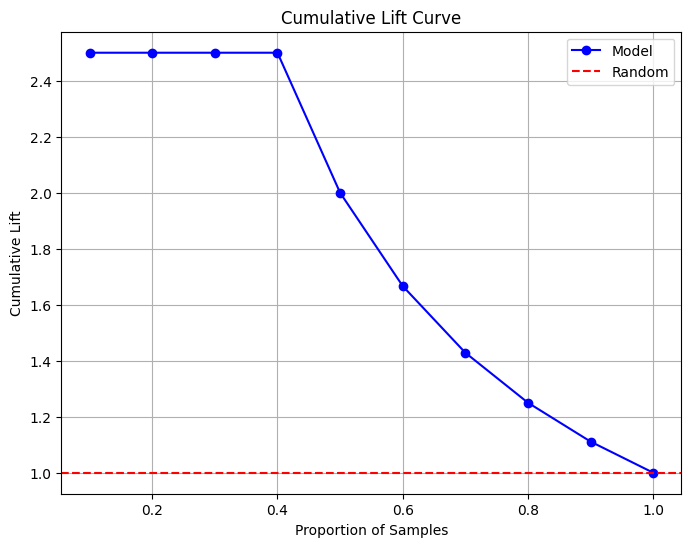

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(y_true) + 1) / len(y_true), cumulative_lift_values, marker='o', linestyle='-', color='b')
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel('Proportion of Samples')
plt.ylabel('Cumulative Lift')
plt.title('Cumulative Lift Curve')
plt.legend(['Model', 'Random'])
plt.grid(True)
plt.show()

## **Bias Variance Trade-off**

In general, as the number of tunable parameters in a model increase, it becomes more flexible, and can better fit a training data set. That is, the model has lower error or lower bias. However, for more flexible models, there will tend to be greater variance to the model fit each time we take a set of samples to create a new training data set (i.e. the test set). It is said that there is greater variance in the model's estimated parameters.
- The bias error is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).
- The variance is an error from sensitivity to small fluctuations in the training set. High variance may result from an algorithm modeling the random noise in the training data (overfitting).

Consider an example of a student going to attend a math exam. Now the task is studying the book or the relevant chapters/modules for the exam.

If the student studies by just skimming over the topics and chapters instead of actually studying the same then the same student will not be able to perform well in the exam as he/she had only skimmed the topic.

Consider another scenario wherein the student memorizes all the contents in the chapters and problems instead of actually studying/understanding the concept,theories and its implication — In this case if any question which comes out of the book but based on the concepts, that student will not be able to tackle or counter the problem.

The ideal one is that we must be able to generalize the model. (i.e) In the above case, we must be able to resolve any problem by studying the concepts, theories and approach for the problem rather than skimming or memorizing the problems.

![image](images/bias_variance.png)

- $\text{MSE}_{test} = \text{Reducible error} + \text{Irreducible error}$- 
- $\text{MSE}_{test} = \text{Variance} + \text{Bias}^2 + \text{Irreducible error}$

The closer the model predictions are to the observations, the smaller the MSE will be. However, we only care about test MSE – the MSE when our model is applied to unseen data. This is because we only care about how the model will perform on unseen data, not existing data.

For example, it’s nice if a model that predicts stock market prices has a low MSE on historical data, but we really want to be able to use the model to accurately forecast future data.

It turns out that the test MSE can always be decomposed into two parts:
1. The variance: Refers to the amount by which our function f would change if we estimated it using a different training set.
2. The bias: Refers to the error that is introduced by approximating a real-life problem, which may be extremely complicated, by a much simpler model.

# **Extra Reading**

https://medium.com/data-science/is-f1-score-really-better-than-accuracy-5f87be75ae01

https://medium.com/data-science/bias-variance-tradeoff-explained-a-visual-guide-with-code-examples-for-beginners-9521871f728a

https://medium.com/data-science/confidence-interval-vs-prediction-interval-a6b0c4816a92